In the following script, a finite element solver to simulate poroelastic problems is developed and subsequentialy benchmarked by Mandels' problem. As the result shows, the pressure at the left end of the domain initially increases, before it later decreases to the final zero value, which is the so-called the Mandel-Cryer effect.

In [1]:
%matplotlib inline

# Import libraries
# dolfin is FEniCS's Python interface
from dolfin import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Constants used in this model
perm  = 1.0e-15      # permeability
visc  = 1.0e-6       # viscosity
mobility = perm/visc # mobility
E  = 100.0e6         # Young's modulus
nu = 0.25            # Poisson ratio
load = -1.0e4        # load from top

# Time variables
dt = 1.0e-3          # time step length
t = dt               # current time
T = 1.0e0            # stop time

# Create a domain of nx*nx grids
mesh = UnitSquareMesh(30, 30)

# Mark domain boundary, required for defining boundary condtions
left  = CompiledSubDomain("near(x[0], 0.)")
right = CompiledSubDomain("near(x[0], 1.)")
top  = CompiledSubDomain("near(x[1], 1.)")
bottom = CompiledSubDomain("near(x[1], 0.)")

# Label boundaries, required for the objective
boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundary_parts.set_all(0)
left.mark(boundary_parts, 1)
right.mark(boundary_parts, 2)
top.mark(boundary_parts, 3)
bottom.mark(boundary_parts, 4)
ds = Measure("ds", subdomain_data=boundary_parts)

# Define function spaces and mixed (product) space
BDM = FiniteElement("BDM", mesh.ufl_cell(), 1)
DG  = FiniteElement("DG", mesh.ufl_cell(), 0)
VS = VectorElement('CG', mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, MixedElement(BDM, DG, VS))

# Vectors of solution variables
# w is solution at current time step
# w0 is solution at previous time step
w = Function(W)
w0= Function(W)

# u is velocity, p is pressure and us is displacement
(u, p, us) = split(w)
(u0, p0, us0) = split(w0)
(v, q, vs) = TestFunctions(W)

# No flux expression class
class NoFluxClass(Expression):
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
    def eval_cell(self, values, x, ufc_cell):
        cell = Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        g = 0.0
        values[0] = g*n[0]
        values[1] = g*n[1]
    def value_shape(self):
        return (2,)
noFlux = NoFluxClass(mesh, degree=2)

# Stress = effective stress - pressure*I
def stress(us, p):
    strain=sym(grad(us))
    term = E/(1.0+nu)/(1.0-2.0*nu)
    sigma = as_tensor([ \
        [term*(1.0-nu)*strain[0,0]+term*nu*strain[1,1]-p, term*(1.0-2.0*nu)*strain[0,1]],\
        [term*(1.0-2.0*nu)*strain[1,0], term*(1.0-nu)*strain[1,1]+term*nu*strain[0,0]-p] \
        ])
    return sigma

# Define variational forms of the dary equation,
# the mass conservation and stress balance equation
F_darcy = dot(u, v)*dx - mobility*div(v)*p*dx
F_mass = (nabla_div(us) - nabla_div(us0))*q/dt*dx + nabla_div(u)*q*dx
F_stress = inner(stress(us, p), grad(vs))*dx - inner(Constant((0.0, load)), vs)*ds(3)
F = F_darcy + F_mass + F_stress

# Fluid boundary condition
# No flux at left, top and bottom edge
bc1 = [DirichletBC(W.sub(0), noFlux, left),\
       DirichletBC(W.sub(0), noFlux, top),\
       DirichletBC(W.sub(0), noFlux,bottom )]

# Solid boundary condition
# Zero displacement in X direction on left edge
# Zero displacement in Ydirection on bottom edge
bc2 = [DirichletBC(W.sub(2).sub(0), Constant(0.0), left),\
       DirichletBC(W.sub(2).sub(1), Constant(0.0), bottom)]

bc = bc1 + bc2

# Define trial function
dw   = TrialFunction(W)
J = derivative(F, w, dw)

# Define problem and solver
# A nonlinear solver is used, though the problem
# is actually linear
problem = NonlinearVariationalProblem(F, w, bc, J)
solver  = NonlinearVariationalSolver(problem)

# Locations to store pressure values
locations = np.linspace(0,1,31)
records = []

# Time steps 
while t <= T:
    
    # Solve the equations
    solver.solve()
    
    # Update w0 with w
    w0.vector()[:] = w.vector()
    
    # Record pressure values
    # At each step, pressure values at line y=0 are recorded
    records.append([w.sub(1)(loca,0.0) for loca in locations])

    # Update t
    t += dt
print('completed')

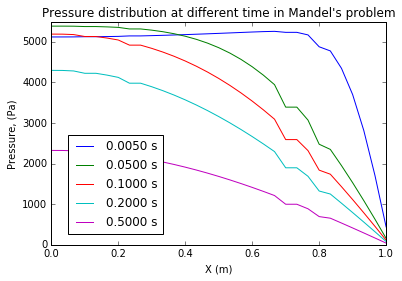

In [5]:
rowsToPlot = [50, 500, 1000, 2000, 5000]
for row in rowsToPlot:
    plt.plot(locations,records[row], label='%.4f s'%(row*0.0001))
plt.ylim(ymin=0,ymax=5500)
plt.legend(bbox_to_anchor=(.05, .05), loc=3, borderaxespad=0.)
plt.xlabel('X (m)')
plt.ylabel('Pressure, (Pa)')
plt.title("Pressure distribution at different time in Mandel's problem")
plt.show()